In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy
warnings.simplefilter("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['axes.unicode_minus'] = False 

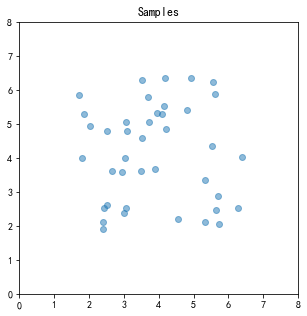

In [2]:
np.random.seed(5213)
x = np.random.rand(40, 2) * 5  + 1.5

plt.figure(figsize=(5, 5))
plt.title("Samples")
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()

In [3]:
class Ane(object):
    
    # 创建函数
    def __init__(self, x, loops, name, points, start, prob):
        self.x = x
        self.loops = loops
        self.v_name = name
        self.v_start = start
        self.v_loc_now = self.v_start
        self.v_loc_next = None
        self.v_points = points
        self.v_prob = prob
        self.v_paths = [self.v_start] 
        self.v_candidates = [i for i in range(self.v_points) if i != self.v_start] 
        self.v_distance_ls = list()
        self.v_distance = None
        self.v_info = 10.0
        self.v_info_delta_ls = None
        self.v_info_matrix = None
        pass
    
  
    # 选择方向
    def f_direction(self):
        # 90%的概率按照信息素浓度选择方向，10%的概率随机选择方向
        if np.random.rand()>=self.v_prob:
            loc_next = np.random.choice(self.v_candidates)
            self.loc_next = loc_next
            pass
        else:
            global df_info
            ix = self.v_loc_now 
            iy = [i for i in self.v_candidates if i not in self.v_paths]
            infos = df_info.iloc[[ix], iy]
            locs = infos.columns.tolist()
            probs = infos.values.tolist()[0]            
            arg = np.array(probs).argmax()
            self.loc_next = locs[arg]
            pass
        pass
    
    
    # 前进一步
    def f_move(self):
        loc_next = self.loc_next
        self.v_paths.append(loc_next)
        self.v_candidates.remove(loc_next)
        self.v_loc_now = loc_next
        pass
    
    # 行走一圈
    def f_circle(self):
        while len(self.v_candidates)>0:
            self.f_direction()
            self.f_move()
        self.loc_next = self.v_start
        self.v_paths.append(self.loc_next)
        self.v_loc_now = self.loc_next
        pass
    
    
    # 计算路径行走的距离
    def f_distance(self):
        distance = 0
        self.v_distance_ls = list()
        for i in range(len(self.v_paths)-1):
            x1, x2 = x[self.v_paths[i]], x[self.v_paths[i+1]]
            dis = np.sqrt(np.sum((x1 - x2)**2))
            distance += dis
            self.v_distance_ls.append(dis)
        self.v_distance = distance
        pass
    
    
    # 留下的信息素浓度
    def f_info_delta(self):
        self.v_info_delta_ls = self.v_info / np.array(self.v_distance_ls)**2
        pass
    
    # 更新信息素矩阵
    def f_update_info_matrix(self):
        global df_info
        self.v_info_matrix = pd.DataFrame(np.zeros(df_info.shape))
        for i in range(len(self.v_paths)-1):
            loc1, loc2 = self.v_paths[i], self.v_paths[i+1]
            self.v_info_matrix.iloc[loc1, loc2] += self.v_info_delta_ls[i]
            pass
        pass
    
    # 调用
    def run(self):
        self.f_circle()
        self.f_distance()
        self.f_info_delta()
        self.f_update_info_matrix()
        pass
    
    def run_loops(self):
        x = self.x
        
        def f_prob_change(x, nums):
            # return np.power(np.exp(x*1.9-nums), 0.01)
            return (x / nums)**2

        # 节点之间的信息素矩阵
        df_info = np.zeros((len(x), len(x))) + 0.001
        for i in range(len(x)):
            df_info[i, i] = 0
        df_info = pd.DataFrame(df_info)

        # 最优结果保存
        best_distance = np.inf
        best_paths = None
        best_id = None

        # 超参数设置
        loops = self.loops
        # loops = 2000 + 1 # 蚂蚁的批次
        # loops = len(x)**2 * 4 + 1
        nums = 8 # 每批蚂蚁的数量
        p_min = 0.9 # 按照信息素选择方向的概率 p
        info_rate_old = 0.7 # 每次迭代，旧信息的保留百分比
        info_rate_new = 0.3 # 每次迭代，新信息的保留百分比

        # 迭代开始
        for loop in range(loops):
            p = min(p_min, f_prob_change(loop, loops)) # 按照信息素选择方向的概率会越来越大
            ane = Ane(name="ane-1", points=len(x), start=0, prob=p)
            ane.run()
            df_tmp = copy.copy(ane.v_info_matrix)
            for i in range(nums):
                ane = Ane(name="ane-1", points=len(x), start=0, prob=p)
                ane.run()
                df_tmp += ane.v_info_matrix
                if ane.v_distance <= best_distance:
                    best_distance = ane.v_distance
                    best_paths= ane.v_paths
                    best_id = (loop, i)
            df_tmp = df_tmp/nums
            df_info = info_rate_old * df_info + info_rate_new * df_tmp
            if loop % 100 == 0:
                # print(f"loop = {loop:>4d} finished! p = {p:>4f}")
                pass
        return 
    pass

In [4]:
%%time

def f_prob_change(x, nums):
    # return np.power(np.exp(x*1.9-nums), 0.01)
    return (x / nums)**2

# 节点之间的信息素矩阵
df_info = np.zeros((len(x), len(x))) + 0.001
for i in range(len(x)):
    df_info[i, i] = 0
df_info = pd.DataFrame(df_info)

# 最优结果保存
best_distance = np.inf
best_paths = None
best_id = None

# 超参数设置
loops = 2000 + 1 # 蚂蚁的批次
# loops = len(x)**2 * 4 + 1
nums = 8 # 每批蚂蚁的数量
p_min = 0.9 # 按照信息素选择方向的概率 p
info_rate_old = 0.7 # 每次迭代，旧信息的保留百分比
info_rate_new = 0.3 # 每次迭代，新信息的保留百分比

# 迭代开始
for loop in range(loops):
    p = min(p_min, f_prob_change(loop, loops)) # 按照信息素选择方向的概率会越来越大
    ane = Ane(name="ane-1", points=len(x), start=0, prob=p)
    ane.run()
    df_tmp = copy.copy(ane.v_info_matrix)
    for i in range(nums):
        ane = Ane(name="ane-1", points=len(x), start=0, prob=p)
        ane.run()
        df_tmp += ane.v_info_matrix
        if ane.v_distance <= best_distance:
            best_distance = ane.v_distance
            best_paths= ane.v_paths
            best_id = (loop, i)
    df_tmp = df_tmp/nums
    df_info = info_rate_old * df_info + info_rate_new * df_tmp
    if loop % 100 == 0:
        print(f"loop = {loop:>4d} finished! p = {p:>4f}")

# 转成概率分布
df_rate = df_info / df_info.sum(axis=0)

loop =    0 finished! p = 0.000000
loop =  100 finished! p = 0.002498
loop =  200 finished! p = 0.009990
loop =  300 finished! p = 0.022478
loop =  400 finished! p = 0.039960
loop =  500 finished! p = 0.062438
loop =  600 finished! p = 0.089910
loop =  700 finished! p = 0.122378
loop =  800 finished! p = 0.159840
loop =  900 finished! p = 0.202298
loop = 1000 finished! p = 0.249750
loop = 1100 finished! p = 0.302198
loop = 1200 finished! p = 0.359640
loop = 1300 finished! p = 0.422078
loop = 1400 finished! p = 0.489510
loop = 1500 finished! p = 0.561938
loop = 1600 finished! p = 0.639360
loop = 1700 finished! p = 0.721778
loop = 1800 finished! p = 0.809191
loop = 1900 finished! p = 0.900000
loop = 2000 finished! p = 0.900000
Wall time: 2min 39s


In [5]:
# df_info.applymap(lambda x: np.round(x, 4))

In [6]:
# df_rate.applymap(lambda x: np.round(x, 4))

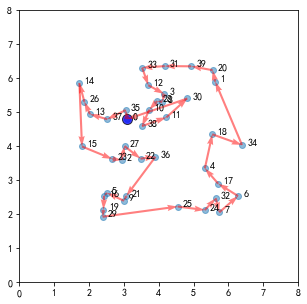

best_id = (1875, 3)
best_paths = 0 -> 35 -> 37 -> 13 -> 26 -> 14 -> 15 -> 23 -> 2 -> 27 -> 22 -> 36 -> 21 -> 9 -> 5 -> 16 -> 19 -> 29 -> 25 -> 24 -> 32 -> 7 -> 6 -> 17 -> 4 -> 18 -> 34 -> 1 -> 20 -> 39 -> 31 -> 33 -> 12 -> 3 -> 8 -> 28 -> 10 -> 38 -> 11 -> 30 -> 0
best_distance = 27.612858973375836


In [7]:
plt.figure(figsize=(5, 5))
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.scatter(x[0][0], x[0][1], c="blue", edgecolors="black", alpha=0.75, s=100)

for i in range(len(best_paths)-1):
    loc1, loc2 = best_paths[i], best_paths[i+1]
    x1, y1 = x[loc1]
    x2, y2 = x[loc2]
    dx = x2 - x1
    dy = y2 - y1
    plt.quiver(x1, y1, dx, dy, angles='xy', scale=1, scale_units='xy', color="red", alpha=0.5)

for i in range(len(x)):
    x1, y1 = x[i]
    plt.annotate(i, xy=(x1, y1), xytext=(x1+0.15, y1))
plt.show()
    
print(f"best_id = {best_id}")
print(f"best_paths = {' -> '.join([str(i) for i in best_paths])}")
print(f"best_distance = {best_distance}")

### 结果

集合大的情况下，难以达到最优结果，次优也能接受